In [1]:
!pip install segmentation-models-pytorch 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.5/450.5 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e9ea1c55f42089730e5bc41071d2e242da729aa86deaeef5c71cf76df48573d4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=e0fa17f44da1174847b8552c28f7e

In [2]:
!wget -P /kaggle/working/samples https://img.pikbest.com/origin/10/43/70/04VpIkbEsTjqx.jpg!sw800

--2024-12-23 16:09:12--  https://img.pikbest.com/origin/10/43/70/04VpIkbEsTjqx.jpg!sw800
Resolving img.pikbest.com (img.pikbest.com)... 104.18.27.9, 104.18.26.9
Connecting to img.pikbest.com (img.pikbest.com)|104.18.27.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71271 (70K) [image/jpeg]
Saving to: ‘/kaggle/working/samples/04VpIkbEsTjqx.jpg!sw800’

04VpIkbEsTjqx.jpg!s 100%[===================>]  69.60K  --.-KB/s    in 0.004s  

2024-12-23 16:09:13 (17.9 MB/s) - ‘/kaggle/working/samples/04VpIkbEsTjqx.jpg!sw800’ saved [71271/71271]



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:00<00:00, 363MB/s]


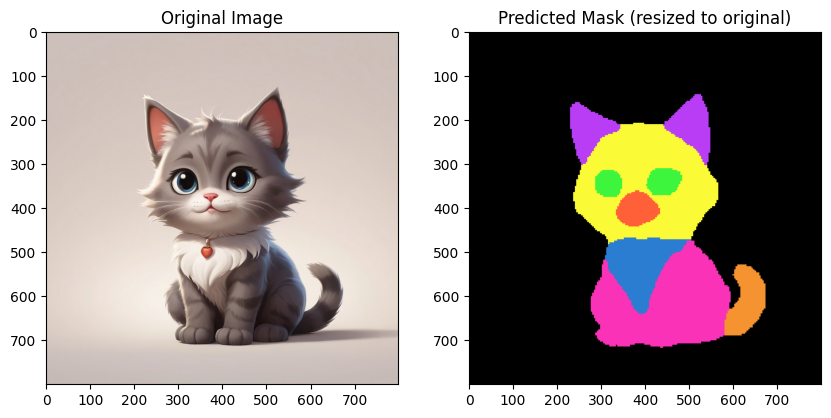

Classes:
0: background
1: cat_body
2: cat_ears
3: cat_eyes
4: cat_face
5: cat_feets
6: cat_muzzle
7: cat_tail


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Danh sách classes và color map
VOC_CLASSES = [
    "background",
    "cat_body",
    "cat_ears",
    "cat_eyes",
    "cat_face",
    "cat_feets",
    "cat_muzzle",
    "cat_tail",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [42, 125, 209],
    [184, 61, 245],
    [61, 245, 61],
    [250, 250, 55],
    [250, 50, 183],
    [255, 96, 55],
    [245, 147, 49],
]

# Mean và std của ImageNet (thường dùng với ResNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Lớp UnNormalize
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return torch.clamp(tensor, 0, 1)

unorm = UnNormalize(mean=mean, std=std)

def img_transform():
    test_transform = A.Compose([
        A.Resize(224, 224),   # Resize về 224x224 vì model train ở kích thước này
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
    return None, test_transform

_, test_transform = img_transform()

def load_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig_img = img.copy()

    transformed = test_transform(image=img)
    img_tensor = transformed["image"]
    
    return orig_img, img_tensor

def predict_image(model_pth, img_path, device="cpu"):
    # Load mô hình
    checkpoint = torch.load(model_pth, map_location=device)
    num_classes = len(VOC_CLASSES)
    model = smp.DeepLabV3Plus(
        encoder_name="resnext101_32x8d",
        encoder_weights="imagenet",
        in_channels=3,
        classes=num_classes
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Load ảnh
    orig_img, img_tensor = load_image(img_path)
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    # Dự đoán
    with torch.no_grad():
        pred = model(img_tensor)
    pred_mask = pred.argmax(dim=1).squeeze(0).cpu().numpy()

    # Gán màu cho pred_mask
    color_pred_mask = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
    for c, color in enumerate(VOC_COLORMAP):
        color_pred_mask[pred_mask == c] = np.array(color, dtype=np.uint8)

    # Resize color_pred_mask về kích thước gốc của ảnh
    orig_height, orig_width = orig_img.shape[:2]
    color_pred_mask_resized = cv2.resize(color_pred_mask, (orig_width, orig_height), interpolation=cv2.INTER_NEAREST)

    # Hiển thị ảnh gốc và mask phóng to
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(orig_img)
    plt.title("Original Image")
    # Không tắt axis để hiển thị thước đo
    # plt.axis("off") # Bỏ dòng này

    plt.subplot(1,2,2)
    plt.imshow(color_pred_mask_resized)
    plt.title("Predicted Mask (resized to original)")
    # plt.axis("off") # Bỏ dòng này

    plt.show()

    # In thông tin về classes
    print("Classes:")
    for i, cls in enumerate(VOC_CLASSES):
        print(f"{i}: {cls}")

# Ví dụ sử dụng:
model_pth = "/kaggle/input/model-segmentation/cat-segbest.h5"
img_path = "/kaggle/working/samples/04VpIkbEsTjqx.jpg!sw800"
device = "cuda" if torch.cuda.is_available() else "cpu"

predict_image(model_pth, img_path, device=device)


In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Danh sách classes và color map
VOC_CLASSES = [
    "background",
    "cat_body",
    "cat_ears",
    "cat_eyes",
    "cat_face",
    "cat_feets",
    "cat_muzzle",
    "cat_tail",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [42, 125, 209],
    [184, 61, 245],
    [61, 245, 61],
    [250, 250, 55],
    [250, 50, 183],
    [255, 96, 55],
    [245, 147, 49],
]

# Mean/std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Hàm test_transform resize về 224x224 giống lúc train
def img_transform():
    test_transform = A.Compose([
        A.Resize(224, 224),   
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
    return None, test_transform

_, test_transform = img_transform()

def load_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig_img = img.copy()

    transformed = test_transform(image=img)
    img_tensor = transformed["image"]
    return orig_img, img_tensor

def predict_image(model_pth, img_path, device="cpu"):
    # Load mô hình
    checkpoint = torch.load(model_pth, map_location=device)
    num_classes = len(VOC_CLASSES)
    model = smp.DeepLabV3Plus(
        encoder_name="resnext101_32x8d",
        encoder_weights="imagenet",
        in_channels=3,
        classes=num_classes
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Load ảnh
    orig_img, img_tensor = load_image(img_path)
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    # Dự đoán
    with torch.no_grad():
        pred = model(img_tensor)
    pred_mask_small = pred.argmax(dim=1).squeeze(0).cpu().numpy() # mask 224x224

    # Resize mask về kích thước gốc
    orig_height, orig_width = orig_img.shape[:2]
    # Phóng to mask (class map) về kích thước gốc
    pred_mask_resized = cv2.resize(pred_mask_small, (orig_width, orig_height), interpolation=cv2.INTER_NEAREST)

    # Các lớp cần xuất ra, theo thứ tự yêu cầu:
    # cat_face (4), cat_ears (2), cat_eyes (3), cat_muzzle (6), cat_body (1), cat_feets (5), cat_tail (7)
    class_order = [4, 2, 3, 6, 1, 5, 7,0]
    
    objects_data = {"objects": []}
    
    for class_idx in class_order:
        class_name = VOC_CLASSES[class_idx]
        # Tạo mask nhị phân cho lớp này
        mask_array = (pred_mask_resized == class_idx).astype(np.uint8)
        
        obj_dict = {
            "class_name": class_name,
            "id": class_idx,
            "parts": {
                "whole": mask_array
            }
        }
        objects_data["objects"].append(obj_dict)

    # Lưu kết quả vào result.npz
    np.savez("result.npz", objects=objects_data)
    print("result.npz đã được lưu thành công.")

    # Kiểm tra kết quả
    data = np.load("result.npz", allow_pickle=True)
    objects_data_loaded = data["objects"].item()  # Lấy dictionary objects_data
    object_list = objects_data_loaded["objects"]

    print(f"Có {len(object_list)} đối tượng trong dữ liệu:\n")
    for i, obj in enumerate(object_list, start=1):
        print(f"Đối tượng {i}:")
        print(f"  class_name: {obj['class_name']}")
        print(f"  id: {obj['id']}")
        print(f"  parts keys: {list(obj['parts'].keys())}")
        
        mask = obj['parts']['whole']
        print(f"  Mask shape: {mask.shape}, dtype: {mask.dtype}, unique: {np.unique(mask)}")
        print()

# Ví dụ sử dụng:
model_pth = "/kaggle/input/model-segmentation/cat-segbest.h5"
img_path = "/kaggle/working/samples/04VpIkbEsTjqx.jpg!sw800"
device = "cuda" if torch.cuda.is_available() else "cpu"
predict_image(model_pth, img_path, device=device)


result.npz đã được lưu thành công.
Có 8 đối tượng trong dữ liệu:

Đối tượng 1:
  class_name: cat_face
  id: 4
  parts keys: ['whole']
  Mask shape: (800, 800), dtype: uint8, unique: [0 1]

Đối tượng 2:
  class_name: cat_ears
  id: 2
  parts keys: ['whole']
  Mask shape: (800, 800), dtype: uint8, unique: [0 1]

Đối tượng 3:
  class_name: cat_eyes
  id: 3
  parts keys: ['whole']
  Mask shape: (800, 800), dtype: uint8, unique: [0 1]

Đối tượng 4:
  class_name: cat_muzzle
  id: 6
  parts keys: ['whole']
  Mask shape: (800, 800), dtype: uint8, unique: [0 1]

Đối tượng 5:
  class_name: cat_body
  id: 1
  parts keys: ['whole']
  Mask shape: (800, 800), dtype: uint8, unique: [0 1]

Đối tượng 6:
  class_name: cat_feets
  id: 5
  parts keys: ['whole']
  Mask shape: (800, 800), dtype: uint8, unique: [0 1]

Đối tượng 7:
  class_name: cat_tail
  id: 7
  parts keys: ['whole']
  Mask shape: (800, 800), dtype: uint8, unique: [0 1]

Đối tượng 8:
  class_name: background
  id: 0
  parts keys: ['whole']


In [5]:
!wget -P /kaggle/working/samples https://t4.ftcdn.net/jpg/00/38/42/39/360_F_38423996_zRFmRjJQbmzSqsk4j5CxEyb1bNtA5e5v.jpg

--2024-12-23 16:09:39--  https://t4.ftcdn.net/jpg/00/38/42/39/360_F_38423996_zRFmRjJQbmzSqsk4j5CxEyb1bNtA5e5v.jpg
Resolving t4.ftcdn.net (t4.ftcdn.net)... 151.101.193.91, 151.101.129.91, 151.101.1.91, ...
Connecting to t4.ftcdn.net (t4.ftcdn.net)|151.101.193.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23906 (23K) [image/jpeg]
Saving to: ‘/kaggle/working/samples/360_F_38423996_zRFmRjJQbmzSqsk4j5CxEyb1bNtA5e5v.jpg’

360_F_38423996_zRFm 100%[===================>]  23.35K  --.-KB/s    in 0s      

2024-12-23 16:09:39 (80.3 MB/s) - ‘/kaggle/working/samples/360_F_38423996_zRFmRjJQbmzSqsk4j5CxEyb1bNtA5e5v.jpg’ saved [23906/23906]



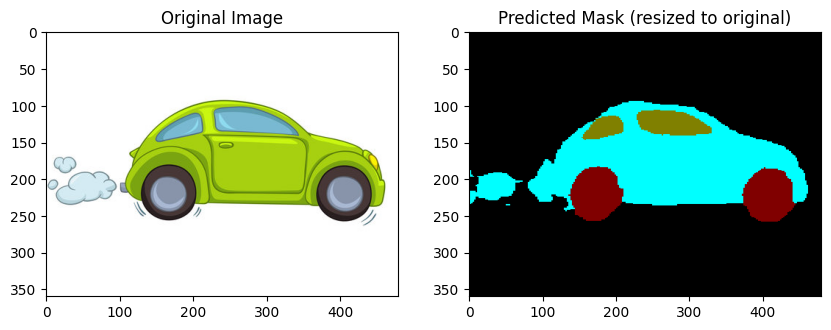

Classes:
0: background
1: car
2: wheel
3: lights
4: windows


In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Danh sách classes và color map
VOC_CLASSES = [
    "background",
    "car",
    "wheel",
    "lights",
    "windows",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [0,255,255],
    [128,0,0],
    [255,255,0],
    [128,128,0],
]


# Mean và std của ImageNet (thường dùng với ResNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Lớp UnNormalize
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return torch.clamp(tensor, 0, 1)

unorm = UnNormalize(mean=mean, std=std)

def img_transform():
    test_transform = A.Compose([
        A.Resize(224, 224),   # Resize về 224x224 vì model train ở kích thước này
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
    return None, test_transform

_, test_transform = img_transform()

def load_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig_img = img.copy()

    transformed = test_transform(image=img)
    img_tensor = transformed["image"]
    
    return orig_img, img_tensor

def predict_image(model_pth, img_path, device="cpu"):
    # Load mô hình
    checkpoint = torch.load(model_pth, map_location=device)
    num_classes = len(VOC_CLASSES)
    model = smp.DeepLabV3Plus(
        encoder_name="resnext101_32x8d",
        encoder_weights="imagenet",
        in_channels=3,
        classes=num_classes
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Load ảnh
    orig_img, img_tensor = load_image(img_path)
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    # Dự đoán
    with torch.no_grad():
        pred = model(img_tensor)
    pred_mask = pred.argmax(dim=1).squeeze(0).cpu().numpy()

    # Gán màu cho pred_mask
    color_pred_mask = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
    for c, color in enumerate(VOC_COLORMAP):
        color_pred_mask[pred_mask == c] = np.array(color, dtype=np.uint8)

    # Resize color_pred_mask về kích thước gốc của ảnh
    orig_height, orig_width = orig_img.shape[:2]
    color_pred_mask_resized = cv2.resize(color_pred_mask, (orig_width, orig_height), interpolation=cv2.INTER_NEAREST)

    # Hiển thị ảnh gốc và mask phóng to
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(orig_img)
    plt.title("Original Image")
    # Không tắt axis để hiển thị thước đo
    # plt.axis("off") # Bỏ dòng này

    plt.subplot(1,2,2)
    plt.imshow(color_pred_mask_resized)
    plt.title("Predicted Mask (resized to original)")
    # plt.axis("off") # Bỏ dòng này

    plt.show()

    # In thông tin về classes
    print("Classes:")
    for i, cls in enumerate(VOC_CLASSES):
        print(f"{i}: {cls}")

# Ví dụ sử dụng:
model_pth = "/kaggle/input/model-segmentation/car-segbest.h5"
img_path = "/kaggle/working/samples/360_F_38423996_zRFmRjJQbmzSqsk4j5CxEyb1bNtA5e5v.jpg"
device = "cuda" if torch.cuda.is_available() else "cpu"

predict_image(model_pth, img_path, device=device)


In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Danh sách classes và color map
VOC_CLASSES = [
    "background",
    "car",
    "wheel",
    "lights",
    "windows",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [0,255,255],
    [128,0,0],
    [255,255,0],
    [128,128,0],
]

# Mean/std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Hàm test_transform resize về 224x224 giống lúc train
def img_transform():
    test_transform = A.Compose([
        A.Resize(224, 224),   
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
    return None, test_transform

_, test_transform = img_transform()

def load_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig_img = img.copy()

    transformed = test_transform(image=img)
    img_tensor = transformed["image"]
    return orig_img, img_tensor

def predict_image(model_pth, img_path, device="cpu"):
    # Load mô hình
    checkpoint = torch.load(model_pth, map_location=device)
    num_classes = len(VOC_CLASSES)
    model = smp.DeepLabV3Plus(
        encoder_name="resnext101_32x8d",
        encoder_weights="imagenet",
        in_channels=3,
        classes=num_classes
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Load ảnh
    orig_img, img_tensor = load_image(img_path)
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    # Dự đoán
    with torch.no_grad():
        pred = model(img_tensor)
    pred_mask_small = pred.argmax(dim=1).squeeze(0).cpu().numpy() # mask 224x224

    # Resize mask về kích thước gốc
    orig_height, orig_width = orig_img.shape[:2]
    # Phóng to mask (class map) về kích thước gốc
    pred_mask_resized = cv2.resize(pred_mask_small, (orig_width, orig_height), interpolation=cv2.INTER_NEAREST)

    # Các lớp cần xuất ra, theo thứ tự yêu cầu:
    class_order = [1, 2, 4, 3, 0]
    
    objects_data = {"objects": []}
    
    for class_idx in class_order:
        class_name = VOC_CLASSES[class_idx]
        # Tạo mask nhị phân cho lớp này
        mask_array = (pred_mask_resized == class_idx).astype(np.uint8)
        
        obj_dict = {
            "class_name": class_name,
            "id": class_idx,
            "parts": {
                "whole": mask_array
            }
        }
        objects_data["objects"].append(obj_dict)

    # Lưu kết quả vào result.npz
    np.savez("result.npz", objects=objects_data)
    print("result.npz đã được lưu thành công.")

    # Kiểm tra kết quả
    data = np.load("result.npz", allow_pickle=True)
    objects_data_loaded = data["objects"].item()  # Lấy dictionary objects_data
    object_list = objects_data_loaded["objects"]

    print(f"Có {len(object_list)} đối tượng trong dữ liệu:\n")
    for i, obj in enumerate(object_list, start=1):
        print(f"Đối tượng {i}:")
        print(f"  class_name: {obj['class_name']}")
        print(f"  id: {obj['id']}")
        print(f"  parts keys: {list(obj['parts'].keys())}")
        
        mask = obj['parts']['whole']
        print(f"  Mask shape: {mask.shape}, dtype: {mask.dtype}, unique: {np.unique(mask)}")
        print()

# Ví dụ sử dụng:
model_pth = "/kaggle/input/model-segmentation/car-segbest.h5"
img_path = "/kaggle/working/samples/360_F_38423996_zRFmRjJQbmzSqsk4j5CxEyb1bNtA5e5v.jpg"
device = "cuda" if torch.cuda.is_available() else "cpu"
predict_image(model_pth, img_path, device=device)


result.npz đã được lưu thành công.
Có 5 đối tượng trong dữ liệu:

Đối tượng 1:
  class_name: car
  id: 1
  parts keys: ['whole']
  Mask shape: (360, 480), dtype: uint8, unique: [0 1]

Đối tượng 2:
  class_name: wheel
  id: 2
  parts keys: ['whole']
  Mask shape: (360, 480), dtype: uint8, unique: [0 1]

Đối tượng 3:
  class_name: windows
  id: 4
  parts keys: ['whole']
  Mask shape: (360, 480), dtype: uint8, unique: [0 1]

Đối tượng 4:
  class_name: lights
  id: 3
  parts keys: ['whole']
  Mask shape: (360, 480), dtype: uint8, unique: [0]

Đối tượng 5:
  class_name: background
  id: 0
  parts keys: ['whole']
  Mask shape: (360, 480), dtype: uint8, unique: [0 1]

